In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
from sklearn.decomposition import PCA 
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt 

from src.features import build_features

import logging 
from pathlib import Path

import scipy
import pickle
import datetime
import numpy as np

logging.basicConfig(level=logging.INFO)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\matan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\matan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Build Features
Use the build_features functions to build dataset from database (usually takes ~1 min)

In [3]:
load_fresh_features = True

proj_path = Path().resolve().parents[1]
processed_path = proj_path / "data" / "processed"

if load_fresh_features:
    today = str(datetime.date.today())
    features, pipe = build_features.bag_of_words_tfid_norm()
    scipy.sparse.save_npz(file=str(processed_path / f"features_{today}-[2].npz"), matrix=features)
    pipe_path = str(processed_path / f"pipe_{today}.pkl")
    with open(pipe_path, 'wb') as file:
        pickle.dump(pipe, file)
    print(f"Date: {today}")
else:
    features, pipe = build_features.load_saved_features(date="2021-03-23")

INFO:src.features.build_features:Building TF-IDF vector + normalizing
INFO:src.features.build_features:Feature building took 17.64 seconds


Date: 2021-03-23


# PCA
To visualize the clustering algorithms I'll use two or three principal components throughout this notebook.

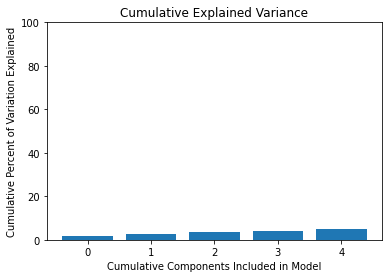

In [4]:
# initialize PCA:
# reduce features:
pca = PCA(n_components=5)
reduced_features = pca.fit_transform(features.toarray())

# display percent explained variance of the first ten components:
fig = plt.figure()
plt.bar(x=range(len(pca.explained_variance_ratio_)), height=np.cumsum(pca.explained_variance_ratio_)*100)
plt.ylim([0, 100])
plt.ylabel("Cumulative Percent of Variation Explained")
plt.xlabel("Cumulative Components Included in Model")
plt.title("Cumulative Explained Variance");

Unfortunately the first two components only seem to code for about 5% (if that) of the percent variation. This makes sense since the bog-of-words is massive, however this means that we cannot trust visual cluster, we'll need some empirical measure of clsuter goodness. 

In [5]:
import pandas as pd
pca.components_[0]

vocab = pipe.named_steps['tfidf_vec'][0].vocabulary_

loadings = pd.DataFrame(data=pca.components_, columns=vocab).T

topics = pd.DataFrame()

for t in loadings.columns:
    topics[str(t)] = loadings[t].sort_values(ascending=False)[:10].index.tolist()
    
topics

,0,1,2,3,4
0,newly,disruptionx,licensed,cut,delete
1,ba,coworking,leadsconducts,philanthropic,chrl
2,sparkr,rule,explorevisualize,conception,leadsconducts
3,uxrs,ocr,supertalented,delete,pertinente
4,comprendre,avanade,wwwgoldmansachscomcareersfooterdisabilitystate...,expertise,automated
5,vicepresident,doit,talentneuron,malaysia,break
6,tourism,postemployment,faster,downstream,forge
7,cost,learningcomputer,damélioration,village,frameworks
8,spotlight,celebrates,systematically,scikitlearn,bloor
9,consistently,réussie,physician,conservation,productive


# SVD

In [10]:
from sklearn.decomposition import TruncatedSVD

svd_model = TruncatedSVD(n_components=3,         # num dimensions
                         algorithm='randomized',
                         n_iter=10)
svd_matrix = svd_model.fit_transform(features)

In [11]:
svd_matrix[0].shape

(3,)

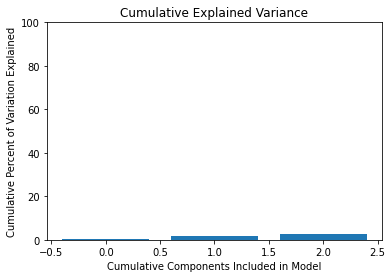

In [12]:
# display percent explained variance of the first ten components:
fig = plt.figure()
plt.bar(x=range(len(svd_model.explained_variance_ratio_)), height=np.cumsum(svd_model.explained_variance_ratio_)*100)
plt.ylim([0, 100])
plt.ylabel("Cumulative Percent of Variation Explained")
plt.xlabel("Cumulative Components Included in Model")
plt.title("Cumulative Explained Variance");

In [13]:
loadings = pd.DataFrame(data=svd_model.components_, columns=vocab).T

topics = pd.DataFrame()

for t in loadings.columns:
    topics[str(t)] = loadings[t].sort_values(ascending=False)[:10].index.tolist()
    
topics

,0,1,2
0,amaze,newly,disruptionx
1,newly,sparkr,coworking
2,creation,ba,ocr
3,latency,uxrs,is
4,sqlssis,vicepresident,learningcomputer
5,graphique,cost,avanade
6,crave,tourism,rule
7,amsterdam,comprendre,postemployment
8,increase,public,doit
9,presentable,consistently,relocate


Not great, although there seems to be a lot of random words that could probably be dealt with better during cleaning/preprocessing

# LDA

In [15]:
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel